# Librerías

In [1]:
import os
import sys

import numpy as np
import pandas as pd 
import random
from glob import glob
import re
from scipy import interp  
from itertools import cycle


import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
%matplotlib inline
import cv2


from sklearn.metrics import SCORERS
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score 
from sklearn.datasets import make_classification 
import sklearn
from imblearn import under_sampling

import tensorflow as tf

from keras.utils import layer_utils, np_utils
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet, vgg16, nasnet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D,Input
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers  
from keras import backend as K 

import pickle

Using TensorFlow backend.


# Importar imágenes

## Funciones

In [2]:
def open_images_names(directory):
    
    """
    **************************************************************
    
    Abre las imagenes de un directorio y las almacena en un array.
    Extrae el nombre del artista del path de la imagen.
    
    Input:
    *directory. Path en el que se encuentran las imágenes.
    Output:
    *np.array con la información de las imágenes
    *np.array con el nombre del artista.
    
    ***************************************************************
    """
    
    images_all = []
    images = glob(directory)
    i_ = 0
    
    for img in images:
        im = cv2.imread(img)
        images_all.append(np.asarray(im))
        i_ += 1
    
    artists = []
    for artist in images:
        art = re.sub("_", " ", (",").join(re.findall("\w+_", artist))[:-1])
        
        if art == "Albrecht ,rer":
            artists.append("Albrecht Dürer")
        else:
            artists.append(art)

        
    return images_all, artists

## Proceso

In [3]:
images, artists = open_images_names("images/**")

# Corregir problemas de balanceo

## Funciones

In [4]:
def countplot_df(df, col):
    
    """
    **************************************************************
    Devuelve un gráfico de barras con los parámetros de visualización
    indicados
    Input:
    *df: dataframe del que extraer la información
    *col: columna que se quiere contar.
    **************************************************************
    
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    plot_df = sns.countplot(df[col], color = "blue")
    _ = plot_df.set_xticklabels(plot_df.get_xticklabels(), rotation=65, horizontalalignment='right')

## Proceso

In [5]:
df = pd.DataFrame(images, columns = ['images'])

In [6]:
df['artist'] = artists

In [7]:
df.head()

,images,artist
0,"[[[87, 99, 101], [43, 55, 57], [33, 42, 45], [...",Pieter Bruegel
1,"[[[84, 136, 149], [88, 140, 153], [87, 139, 15...",Francisco Goya
2,"[[[68, 80, 92], [63, 75, 87], [58, 70, 82], [5...",Paul Cezanne
3,"[[[122, 156, 186], [120, 154, 184], [109, 143,...",Vincent van Gogh
4,"[[[5, 6, 4], [0, 0, 0], [0, 2, 1], [0, 1, 0], ...",Titian


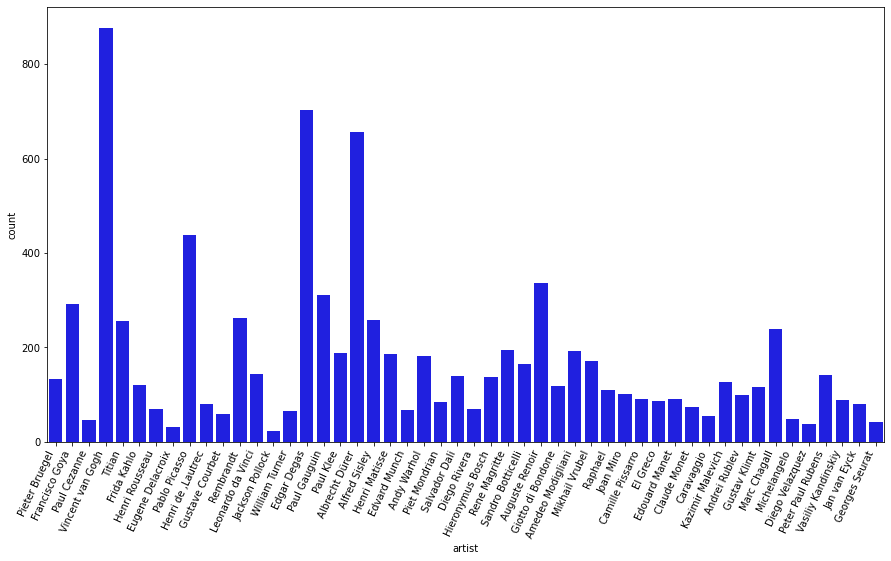

In [8]:
countplot_df(df, 'artist')

# Separar train/test

In [9]:
images_v1=np.asarray(df['images'])
artists =df['artist']

In [10]:
num_classes = len(pd.unique(artists))

In [11]:
le=LabelEncoder()
le_artists = le.fit_transform(artists)
artists_dict = {}
for i in range(0, len(artists)):
    artists_dict[le_artists[i]]=artists[i]

In [12]:
target_names = [artists_dict.get(i) for i in sorted(artists_dict)]

In [13]:
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(images_v1, le_artists, test_size=0.2, random_state=42)

In [14]:
x_train_original, x_val_original, y_train_original, y_val_original = train_test_split(x_train_original, y_train_original, test_size=0.2, random_state=42)

In [15]:
y_train = np.array(np_utils.to_categorical(y_train_original, num_classes))
y_val = np_utils.to_categorical(y_val_original, num_classes)
y_test = np_utils.to_categorical(y_test_original, num_classes)

# Ajustar el tamaño de las imágenes

## Funciones

In [16]:
def resize_data(data):  
    
    """
    **************************************************************
    
    Ajusta el tamaño de la imagen para su estandarización.
    
    ***************************************************************
    """
    
        
    res_data = []
    for i in range(len(data)):
        res = cv2.resize(data[i], dim, interpolation=cv2.INTER_LINEAR)
        res_data.append(res)

    return res_data

In [17]:
def compara_muestras(db1, db2):
        
    """
    **************************************************************
    
    Muestra de forma aleatoria una de las imágenes importadas junto
    con información de su tamaño y autor.
    
    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (15, 8) 
    
    num = random.randrange(len(db1))
    
    print(f'Autor: {artists[num]}')
    print(f'Dimensión original:{db1[num].shape}')
    print(f'Dimensión ajustada:{db2[num].shape}')
    print(f'Filas originales: {db1[num].shape[0]}')
    print(f'Filas ajustadas: {db2[num].shape[0]}')
    print(f'Columnas originales: {db1[num].shape[1]}')
    print(f'Columnas ajustadas: {db2[num].shape[1]}')
    print(f'Profundidad: {db1[num].shape[2]}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Imagen original vs imagen ajustada')

    ax1.imshow(cv2.cvtColor(db1[num], cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title("Imagen original")
    ax2.imshow(cv2.cvtColor(db2[num], cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title("Imagen ajustada")
    plt.show()

## Proceso

In [18]:
dim = (300,300)

In [19]:
x_train = np.asarray(resize_data(x_train_original))

In [20]:
x_test = np.asarray(resize_data(x_test_original))

In [21]:
x_val = np.asarray(resize_data(x_val_original))

Autor: Albrecht Dürer
Dimensión original:(290, 614, 3)
Dimensión ajustada:(300, 300, 3)
Filas originales: 290
Filas ajustadas: 300
Columnas originales: 614
Columnas ajustadas: 300
Profundidad: 3


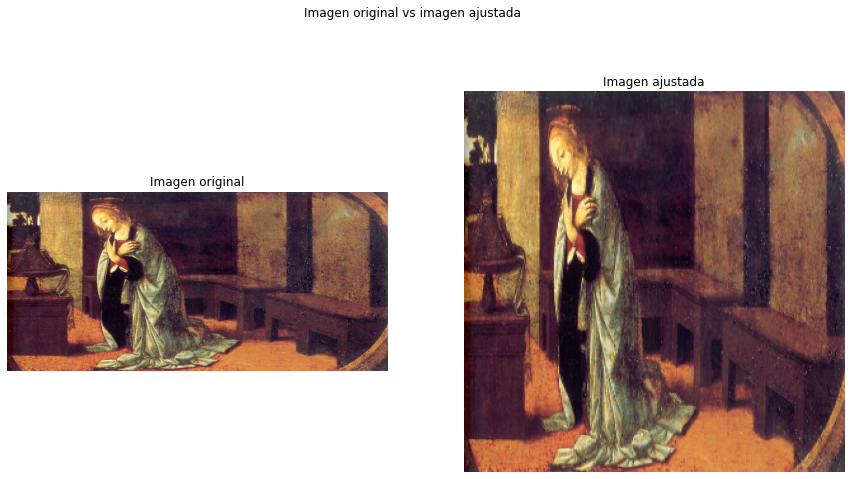

In [22]:
compara_muestras(x_train_original, x_train)

# DataAugmentation

In [23]:
#Este está creado para la visualización
train_generator_viz = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')

#Este es el que pasaremos al modelo con el rescalado de valores
train_generator = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        rescale = 1.0/255)

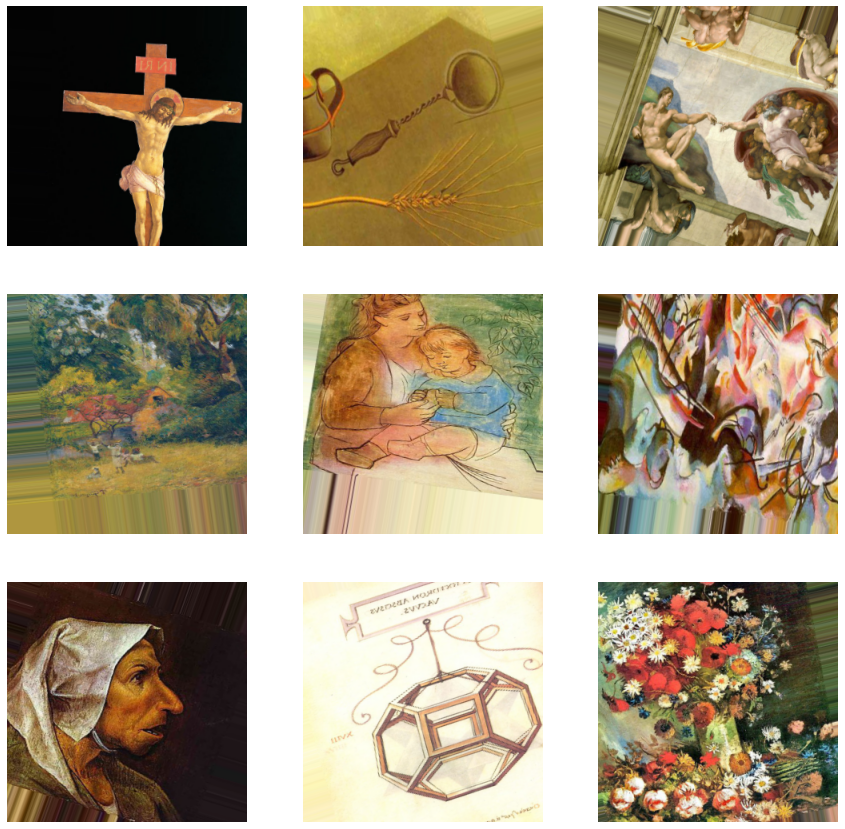

In [24]:
fig = plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator_viz.flow(x_train).next()
    image = batch[0].astype('uint8')
    plt.axis('Off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()

# Empecemos

## Funciones

In [25]:
def conf_matrix(num_classes, model_pred):
    
    """
    **************************************************************
    
    Crea una matriz de confusión del modelo.

    ***************************************************************
    """
    
    #Creamos la matriz de confusión
    model_cm = confusion_matrix(np.argmax(y_test, axis=1), model_pred)

    # Visualizamos la matriz de confusión
    model_df_cm = pd.DataFrame(model_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sns.set(font_scale=1.4) #for label size  
    sns.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}, xticklabels=target_names, 
                yticklabels=target_names, cmap="Blues", vmax = 50)  
    plt.show() 

In [26]:
def plot_train_vs_val (model):
    
    """
    **************************************************************
    
    Visualiza en forma de gráfico las curvas del accuracy y del loss
    entre el train y el test.

    ***************************************************************
    """
    
    plt.rcParams['figure.figsize'] = (8, 6) 
    
    plt.figure(0)  
    plt.plot(model.history['acc'],'r')  
    plt.plot(model.history['val_acc'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Accuracy")  
    plt.title("Training Accuracy vs Validation Accuracy")  
    plt.legend(['train','validation'])

    plt.figure(1)  
    plt.plot(model.history['loss'],'r')  
    plt.plot(model.history['val_loss'],'g')  
    plt.xticks(np.arange(0, 50, 2.0))   
    plt.xlabel("Num of Epochs")  
    plt.ylabel("Loss")  
    plt.title("Training Loss vs Validation Loss")  
    plt.legend(['train','validation'])

    plt.show()

In [27]:
def test_img(model_predicted):
    
    """
    **************************************************************
    
    Devuelve una imagen con el resultado del modelo de predicción
    indicado.
    
    Input:
    -model_predicted: resultados del modelo con el test.
    
    Output:
    -Imagen con la predicción.
    
    
    ***************************************************************
    """
    
    
    #Genera la elección aleatoria de la imagen
    num = random.randrange(len(y_test))
    
    #Imprime la imagenx
    plt.imshow(cv2.cvtColor(x_test_original[num], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    #Busca en el diccionario para devolver el nombre del artista y no la etiqueta
    real= artists_dict.get(np.argmax(y_test[num]))
    predicted= artists_dict.get(model_predicted[num])
    
    #Muestra la etiqueta real y la predicha.
    print(f'Artista real      :   {real}')  
    print(f'Artista predicho  :   {predicted}') 

In [28]:
def guardar(model, model_name):
    
    """
    **************************************************************
    
    Guarda el modelo en formato h5 y su histórico en txt.
    
    Input:
    -model: modelo a guardar
    
    Output:
    -Imagen con la predicción
    
    
    ***************************************************************
    """
    #Modelo
    model.save(model_name+'.h5')
    #Histórico
    with open(model_name + '.txt', 'wb') as file_pi:  
        pickle.dump(model.history, file_pi)

In [29]:
K.set_image_data_format('channels_last')  

In [30]:
K.set_learning_phase(1) 

## Hiperparamétros

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks = [early_stop, reduce_lr] 

In [32]:
epochs = 100
batch_size = 32

# IncepcionResNetV2 con ImageNet

## Creamos la red

In [33]:
def build_IncepcionImagenet_model(layers):
    imagenet_model = InceptionResNetV2(weights='imagenet', include_top=False)
    x = imagenet_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x) 
    imagenet_model = Model(input=imagenet_model.input, output=predictions)
    for layer in imagenet_model.layers[:layers]:
        layer.trainable = False
    
    return imagenet_model

In [45]:
imagenet_model = build_IncepcionImagenet_model(600)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [46]:
imagenet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [47]:
#imagenet_model.summary()

## Entrenamos el modelo

In [48]:
imagenet = imagenet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=batch_size) ,
    steps_per_epoch=len(x_train)// batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = callbacks,
    shuffle=True)

Epoch 1/100
173/173 [==============================] - 126s 726ms/step - loss: 1.9093 - acc: 0.5002 - mse: 0.0128 - val_loss: 1.2959 - val_acc: 0.6525 - val_mse: 0.0097
Epoch 2/100
173/173 [==============================] - 114s 661ms/step - loss: 0.9974 - acc: 0.7285 - mse: 0.0078 - val_loss: 1.1481 - val_acc: 0.6906 - val_mse: 0.0088
Epoch 3/100
173/173 [==============================] - 114s 658ms/step - loss: 0.6995 - acc: 0.8001 - mse: 0.0058 - val_loss: 0.9612 - val_acc: 0.7396 - val_mse: 0.0074
Epoch 4/100
173/173 [==============================] - 113s 655ms/step - loss: 0.5133 - acc: 0.8521 - mse: 0.0044 - val_loss: 0.9880 - val_acc: 0.7259 - val_mse: 0.0076
Epoch 5/100
173/173 [==============================] - 114s 660ms/step - loss: 0.3998 - acc: 0.8854 - mse: 0.0035 - val_loss: 0.9758 - val_acc: 0.7317 - val_mse: 0.0075
Epoch 6/100
173/173 [==============================] - 114s 659ms/step - loss: 0.3058 - acc: 0.9171 - mse: 0.0027 - val_loss: 0.9316 - val_acc: 0.7547 - va

## Evaluamos el modelo

In [49]:
imagenet_evaluation = imagenet_model.evaluate_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), verbose=1) 
imagenet_evaluation

174/174 [==============================] - 94s 539ms/step


[0.005211458541452885, 0.9965803027153015, 0.00014304505020845681]

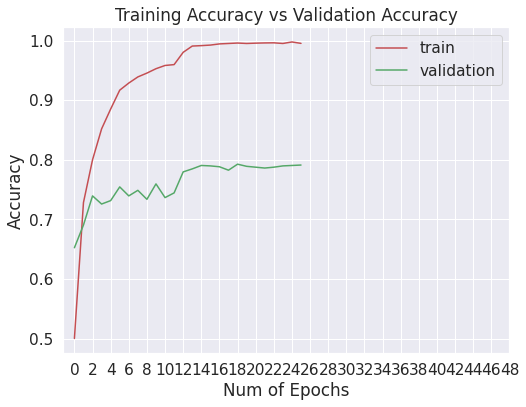

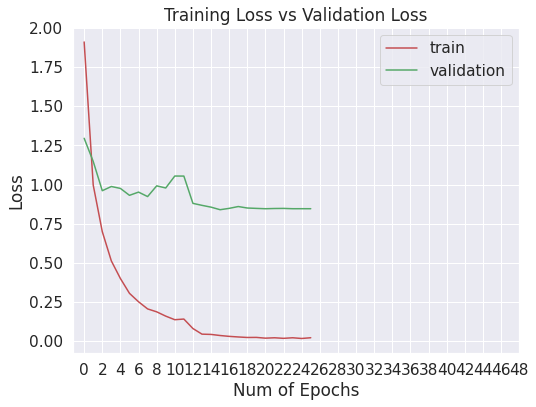

In [50]:
plot_train_vs_val(imagenet)

## Predicción del modelo

In [51]:
imagenet_pred = imagenet_model.predict(x_test, batch_size=batch_size, verbose=1)  
imagenet_predicted = np.argmax(imagenet_pred, axis=1) 

1737/1737 [==============================] - 24s 14ms/step


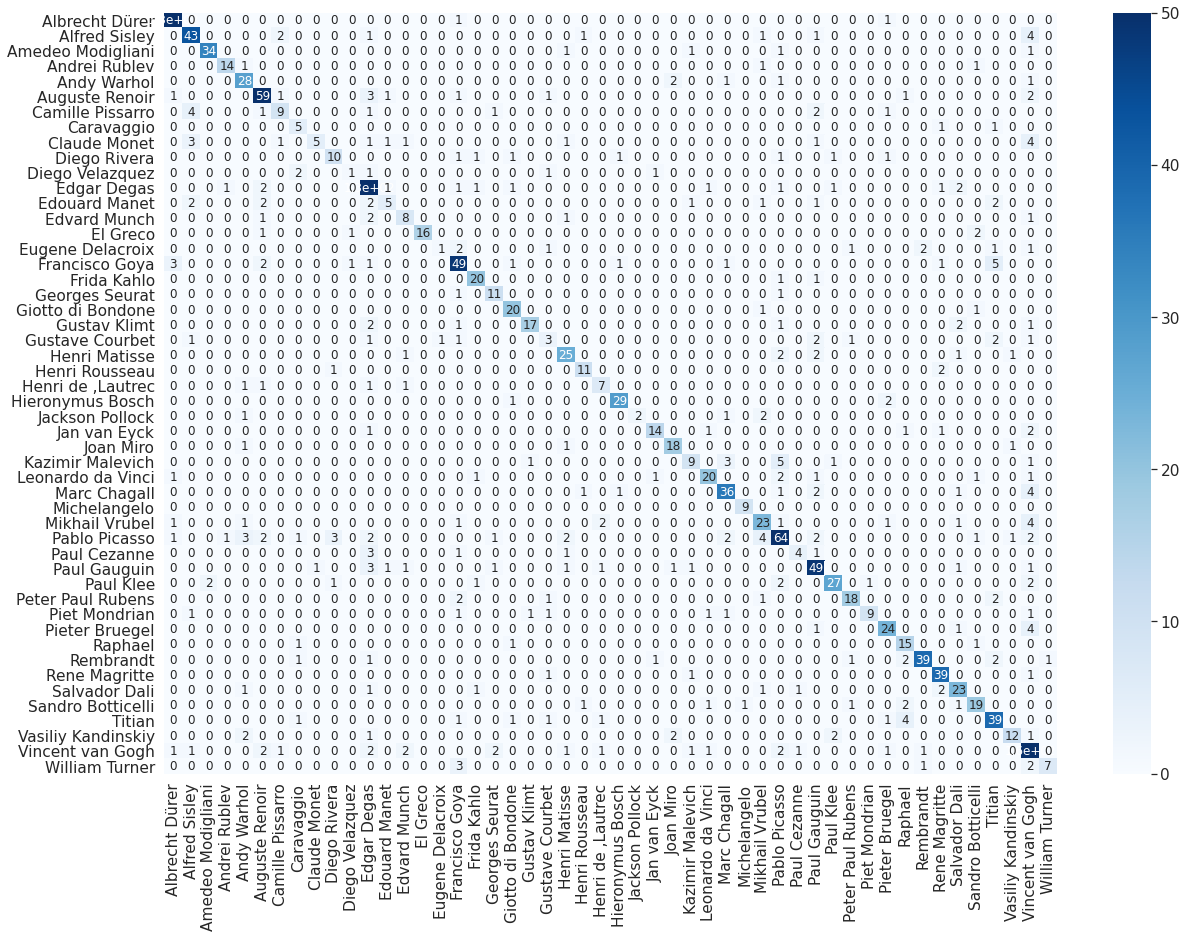

In [52]:
conf_matrix (num_classes, imagenet_predicted)

In [53]:
imagenet_report = classification_report(np.argmax(y_test, axis=1), imagenet_predicted, target_names=target_names)  
print(imagenet_report)

                    precision    recall  f1-score   support

    Albrecht Dürer       0.94      0.99      0.96       134
     Alfred Sisley       0.78      0.81      0.80        53
 Amedeo Modigliani       0.94      0.89      0.92        38
     Andrei Rublev       0.88      0.82      0.85        17
       Andy Warhol       0.72      0.85      0.78        33
    Auguste Renoir       0.81      0.84      0.83        70
  Camille Pissarro       0.64      0.47      0.55        19
        Caravaggio       0.45      0.71      0.56         7
      Claude Monet       0.83      0.28      0.42        18
      Diego Rivera       0.67      0.59      0.62        17
   Diego Velazquez       0.33      0.17      0.22         6
       Edgar Degas       0.81      0.91      0.86       143
     Edouard Manet       0.56      0.31      0.40        16
      Edvard Munch       0.57      0.62      0.59        13
          El Greco       1.00      0.80      0.89        20
  Eugene Delacroix       0.50      0.11

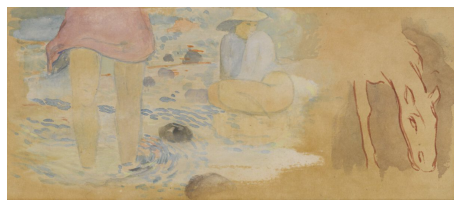

Artista real      :   Paul Gauguin
Artista predicho  :   Salvador Dali


In [54]:
test_img(imagenet_predicted)

## Conclusiones

Un 79% de *accuracy* finalmente. Puede que este parámetro se pudiera mejorar congelando un número diferente de capas. 

## Guardar los resultados

In [44]:
guardar(imagenet_model, "imagenet_model")